In [1]:
# Copyright 2018 Selim Amrouni. All rights reserved.

# Imports

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)


from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import train_test_split


from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.svm import SVC

from sklearn.metrics import log_loss, fbeta_score, make_scorer, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV


from tqdm import tqdm


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import RMSprop, Adam, SGD, Nadam

# Data

## Objective

[Label Emmaüs](https://www.label-emmaus.co/fr/) offers for sale objects renovated or created by the movement Emmaüs. The aim is to estimate the range of time to sale each object.

This is a multi-labels classification, with 3 labels:

- 0 : between 0 et 10 days
- 1 : between 10 et 60 days
- 2 : more than 60 days
<br>
The evaluation metric is multilogloss

## Overall data

In [217]:
X_train = pd.read_csv("X_train.csv", index_col=0, error_bad_lines=False)
X_test = pd.read_csv("X_test.csv", index_col=0, error_bad_lines=False)
y_train = pd.read_csv("y_train.csv", index_col=0)

print("Dimension X_train:", X_train.shape)
print("Dimension X_test:", X_test.shape)

X_train.head(3)

Dimension X_train: (8880, 30)
Dimension X_test: (2960, 30)


b'Skipping line 2168: expected 31 fields, saw 33\nSkipping line 4822: expected 31 fields, saw 37\nSkipping line 4859: expected 31 fields, saw 37\nSkipping line 7342: expected 31 fields, saw 37\n'


,nb_images,longueur_image,largeur_image,url_image,description_produit,taille,matiere,age,garantie,annee,couleur,largeur_produit,wifi,etat,longueur_produit,pointure,vintage,marque,auteur,editions,hauteur_produit,poids,prix,categorie,sous_categorie_1,sous_categorie_2,sous_categorie_3,sous_categorie_4,nom_produit,nom_magasin
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,3458.0,2552.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Superbe petit top bustier avec explosion de co...,44,100 % polyester,NaN,NaN,NaN,Multicolore,NaN,NaN,bon état,NaN,NaN,False,NaN,NaN,NaN,NaN,200.0,4.5,mode,"tops, t-shirts, débardeurs femme",NaN,NaN,NaN,Top bustier multicolore,Emmaüs 88 Neufchateau
1,2,2486.0,2254.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,"Radio ITT Océnic Flirt, année 70\nPour déco",NaN,Plastique,NaN,NaN,NaN,Jaune,NaN,NaN,en l'état,NaN,NaN,True,ITT Océanic,NaN,NaN,NaN,1000.0,15.0,mobilier - deco,bibelots et objets déco,NaN,NaN,NaN,Radio ITT Océanic,Communauté Emmaüs Thouars (magasin Parthenay)
2,3,1536.0,1536.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Veste boléro à manches courtes NÛMPH. Gris chi...,40,"Polyester, coton, laine",NaN,NaN,NaN,Gris,NaN,NaN,neuf,NaN,NaN,False,Nûmph,NaN,NaN,NaN,360.0,16.0,label selection,mode,mode femme,NaN,NaN,NaN,Label Emmaüs Chambéry


The training dataset is the one we have to train the model, we know the labels with y_train. <br>
For the test dataset, we don't know y_test. This is the one we have to submit the results. 

But first, let's split the X_train in 2 parts. <br> We split it randomly in order to get a validation dataset. It will enable us to know the performances of the model before the submission with totally unseen data. <br>
Note that for the final submission, we'll train the chosen model with the whole training dataset. 

## Split X_train

In [218]:
# we save y_train for later with X_train
Y_train = y_train

x_train, x_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

## NaN values

There are 30 different features. However, it seems many have a lot of NaN values. Let's see which ones have enough data.

Let's see the percentage of missing values per columns.

In [219]:
round(100*x_train.isnull().sum()/len(x_train))

nb_images               0.0
longueur_image          1.0
largeur_image           1.0
url_image               1.0
description_produit     0.0
taille                 72.0
matiere                55.0
age                    99.0
garantie               99.0
annee                  83.0
couleur                40.0
largeur_produit        99.0
wifi                   99.0
etat                    0.0
longueur_produit       99.0
pointure               97.0
vintage                33.0
marque                 51.0
auteur                 84.0
editions               84.0
hauteur_produit        99.0
poids                   0.0
prix                    0.0
categorie               0.0
sous_categorie_1       18.0
sous_categorie_2       59.0
sous_categorie_3       90.0
sous_categorie_4       99.0
nom_produit             9.0
nom_magasin             0.0
dtype: float64

A lot of columns are missing a lot of values:
- taille
- matiere
- age
- garantie
- annee
- couleur
- largeur_produit
- wifi
- longueur_produit
- pointure
- marque
- auteur
- editions
- hauteur_produit
- sous_categorie_2
- sous_categorie_3
- sous_categorie_4


In [220]:
X_train = X_train.drop(['taille', 'matiere', 'age', 'garantie', 'annee', 'couleur', 'largeur_produit', 'wifi',
                        'longueur_produit', 'pointure', 'marque', 'auteur', 'editions', 'hauteur_produit',
                        'sous_categorie_2', 'sous_categorie_3', 'sous_categorie_4'], axis=1)

x_train = x_train.drop(['taille', 'matiere', 'age', 'garantie', 'annee', 'couleur', 'largeur_produit', 'wifi',
                        'longueur_produit', 'pointure', 'marque', 'auteur', 'editions', 'hauteur_produit',
                        'sous_categorie_2', 'sous_categorie_3', 'sous_categorie_4'], axis=1)

x_val = x_val.drop(['taille', 'matiere', 'age', 'garantie', 'annee', 'couleur', 'largeur_produit', 'wifi',
                    'longueur_produit', 'pointure', 'marque', 'auteur', 'editions', 'hauteur_produit',
                    'sous_categorie_2', 'sous_categorie_3', 'sous_categorie_4'], axis=1)

X_test = X_test.drop(['taille', 'matiere', 'age', 'garantie', 'annee', 'couleur', 'largeur_produit', 'wifi',
                      'longueur_produit', 'pointure', 'marque', 'auteur', 'editions', 'hauteur_produit',
                      'sous_categorie_2', 'sous_categorie_3', 'sous_categorie_4'], axis=1)

In [221]:
x_train.head(3)

,nb_images,longueur_image,largeur_image,url_image,description_produit,etat,vintage,poids,prix,categorie,sous_categorie_1,nom_produit,nom_magasin
id,,,,,,,,,,,,,
5540,3,1600.0,900.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,<p><strong>Robe Bustier Femme ZARA</strong></p...,neuf,NaN,500.0,7.0,mode,robes,ZARA - T40 ( ref.d39 ),Tri d'Union - la boutique en ligne
5528,5,2450.0,2287.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,"Couturière en herbe , ranger une partie de vot...",bon état,True,3400.0,30.0,loisirs,mobilier - deco,Travailleuse couture vintage,Emmaüs 88 Neufchateau
3434,5,2200.0,2200.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Pot en terre made in Mexico.\nPoterie brute no...,bon état,False,1300.0,6.0,mobilier - deco,Vases et Pots,Pot cache pot poterie made in Mexico,Frip'Insertion Marseille Libération


That's a lot of removed features. Now, we can focus on the remaining data. 

## Features exploration

These are data are different types:
- Categorical: 
 - etat
 - vintage
 - categorie
 - sous_categorie_1
 - nom_magasin
- Text:
 - url_image
 - description_produit
 - nom_produit
- Numerical:
 - nb_images
 - longueur_image
 - largeur_image
 - poids
 - prix
 
 
 
    

### Numerical

We can keep these data and do not apply any transformation. 

### Categorical

#### etat

In [222]:
x_train.etat.value_counts()

bon état         3162
en l'état        1108
comme neuf        767
reconditionné     644
neuf              516
Name: etat, dtype: int64

There are a few categories and there is a relation of order between these data. <br>
neuf > comme neuf > reconditionné > bon état > en l'état <br>
<br>
Let's replace these categorie by corresponding integer. 

In [223]:
def replace(data):
    if data == 'en l\'état':
        return 0
    elif data == 'bon état':
        return 1
    elif data == 'reconditionné':
        return 2
    elif data == 'comme neuf':
        return 3
    elif data == 'neuf':
        return 4

In [224]:
x_train.etat = x_train.apply(lambda x: replace(x.etat), axis=1)
x_val.etat = x_val.apply(lambda x: replace(x.etat), axis=1)
X_test.etat = X_test.apply(lambda x: replace(x.etat), axis=1)
X_train.etat = X_train.apply(lambda x: replace(x.etat), axis=1)

### Vintage

Two labels.

In [225]:
x_train.vintage.value_counts()

False    2728
True     1439
Name: vintage, dtype: int64

In [226]:
def replace(data):
    if data == True:
        return 1
    else:
        return 0


X_train.vintage = X_train.apply(lambda x: replace(x.vintage), axis=1)

x_train.vintage = x_train.apply(lambda x: replace(x.vintage), axis=1)
x_val.vintage = x_val.apply(lambda x: replace(x.vintage), axis=1)

X_test.vintage = X_test.apply(lambda x: replace(x.vintage), axis=1)

### categorie


In [227]:
x_train.categorie.value_counts()

mode                               2117
mobilier - deco                    1265
librairie                          1024
label selection                     656
loisirs                             576
enfance                             380
multimédia                           95
les coups de coeur des vendeurs      34
culture - loisirs                    31
mobilier - deco - maison             28
créations                             9
Name: categorie, dtype: int64

There are a several un-ordered data. However, we can group some data because of the same type:
- mobilier - deco & mobilier - deco - maison


In [228]:
def replace(data):
    if data == 'mobilier - deco - maison':
        return 'mobilier - deco'
    else:
        return data


X_train.categorie = X_train.apply(lambda x: replace(x.categorie), axis=1)

x_train.categorie = x_train.apply(lambda x: replace(x.categorie), axis=1)
x_val.categorie = x_val.apply(lambda x: replace(x.categorie), axis=1)
X_test.categorie = X_test.apply(lambda x: replace(x.categorie), axis=1)

x_train.categorie.value_counts()

mode                               2117
mobilier - deco                    1293
librairie                          1024
label selection                     656
loisirs                             576
enfance                             380
multimédia                           95
les coups de coeur des vendeurs      34
culture - loisirs                    31
créations                             9
Name: categorie, dtype: int64

There is no ordering relation between these categories. So we can't replace by integers. <br>
We can use the one-hot encoding method to replace these variables. So, each category is replace by a binary variable. <br>
This method is implemented in keras or scikit-learn. 

### sous_categorie_1

In [229]:
x_train.sous_categorie_1.value_counts()

mode                                                 372
bibelots et objets déco                              335
label selection                                      263
robes                                                213
accessoires femme                                    210
sacs, maroquinerie                                   160
objets d'art, antiquités                             146
autres objets                                        139
vestes, blazers femme                                131
tops, t-shirts, débardeurs femme                     123
mobilier - deco                                      121
jupes, shorts femme                                  121
tableaux, miroirs, déco murale                       110
chemisiers, blouses, tuniques femme                  104
vinyles                                              100
chaussures et bottes femme                            97
vaisselle à l'unité                                   93
appareils photo et accessoires 

There are 169 different categories. This is a lot. The problem comes up because it will generate a lot of binary variables if we directly use one-hote encoding. <br>
This category is heavy, let's see later the exploitation of this one. 

### nom_magasin

In [230]:
round(x_train.nom_magasin.value_counts()/len(x_train)*100, 2)

Emmaüs Lyon                                               10.28
Emmaüs 88 Neufchateau                                      9.03
Label Emmaüs Chambéry                                      7.66
ADBook - la Librairie Solidaire des Ateliers du Bocage     7.45
Tri d'Union - la boutique en ligne                         6.61
Le Léopard                                                 5.37
Emmaüs Sacré Dressing !                                    5.07
Label Emmaüs de Grenoble                                   4.05
Label Emmaus Angers                                        3.14
Frip'Insertion Marseille Libération                        3.12
Booki - la Librairie Solidaire de Retrilog                 3.06
Emmaüs Saintes Saint Romain                                2.61
Emmaüs Avenir Neuilly sur Marne                            2.48
Emmaüs Alternatives Sélection                              2.25
La Boutique Emmaüs de Lorient Plénéno                      2.20
La Boutique Emmaüs d’Auray              

In [231]:
len(x_train.nom_magasin.value_counts())

45

In [232]:
df = X_train.copy()
df['label'] = Y_train
df.groupby('nom_magasin').mean()['label']

nom_magasin
ADBook - la Librairie Solidaire des Ateliers du Bocage    1.256296
Atelier Emmaüs                                            0.571429
Booki - la Librairie Solidaire de Retrilog                1.287770
Boutique des amis d'Emmaüs Apt                            0.000000
Comité d'amis Emmaüs Beauvais                             0.725490
Comité d'amis Emmaüs Millau                               0.931298
Comité d'amis Emmaüs Pont Audemer                         0.702703
Comité d'amis Emmaüs Roanne Mably                         0.666667
Comité d'amis Emmaüs Ruffec                               0.142857
Comité d'amis Emmaüs le Puy en Velay                      0.000000
Communauté Emmaüs Angoulême                               0.413793
Communauté Emmaüs Soissons                                0.310924
Communauté Emmaüs Thouars                                 0.000000
Communauté Emmaüs Thouars (magasin Parthenay)             0.416667
Ding Fring - En page solidaire                    

There are a lot of categories (46). We can want to reduce the number by grouping stores together: let's say we keep top15 in volume of sells and then group the rest under one label. <br><br>
However, as shown above, the feature 'nom_magasin' seems really important because this is a feature with a great variance. <br>So we keep all the labels.


There is no ordering relation, so we'll use one-hot encoding. 

In [233]:
# list_top_15 = list(X_train.nom_magasin.value_counts().index[0:15])
# def replace(data):
#     if data in list_top_15:
#         return data
#     else:
#         return 'other_store'

    
# X_train.nom_magasin = X_train.apply(lambda x: replace(x.nom_magasin), axis = 1)
# x_train.nom_magasin = x_train.apply(lambda x: replace(x.nom_magasin), axis = 1)
# x_val.nom_magasin = x_val.apply(lambda x: replace(x.nom_magasin), axis = 1)
# X_test.nom_magasin = X_test.apply(lambda x: replace(x.nom_magasin), axis = 1)

# round(X_train.nom_magasin.value_counts()/len(X_train)*100,2)

## Text

### Feature Description

#### url_image

This feature seems not relevant. Let's remove it. 

#### description_produit

This feature is pure text. It is a description of the product. I assume this feature should be useful. Indeed, this translate the sentiment of the author when he sees the product. So this should be the sentiment of a potential buyer. <br>
Further exploration should be done with text mining technics.<br> <br>
Also, we can assume the length of the description and the title(nom_produit) are 2 important features. Indeed, a long description could attract a potential buyer: more details. We also count the number of words because it demonstrates the richness of the vocabulary: a rich vocabulary could be used for really nice products/a poorest for less attractive product. 

#### nom_produit

In [234]:
x_train.nom_produit.head(7)

id
5540                               ZARA - T40 ( ref.d39 )
5528                        Travailleuse couture vintage 
3434                 Pot cache pot poterie made in Mexico
5621    Souveraineté du vide. Lettres d'or - Christian...
5267                             Ancienne Poupée Corolle 
2589                                                  NaN
4782                                                  NaN
Name: nom_produit, dtype: object

Same remark. 

### Text Mining 

First we need to clean the NaN sentences. 

In [235]:
x_val.nom_magasin.fillna('', inplace=True)
X_test.nom_magasin.fillna('', inplace=True)
X_train.nom_magasin.fillna('', inplace=True)
x_train.nom_magasin.fillna('', inplace=True)

x_val.nom_produit.fillna('', inplace=True)
X_test.nom_produit.fillna('', inplace=True)
X_train.nom_produit.fillna('', inplace=True)
x_train.nom_produit.fillna('', inplace=True)
pass

#### Length 

In [236]:
def length_character(var):
    """Takes a string returns the number of characters """
    return len(var)


def length_word(var):
    """Takes a string and returns the numbers of words"""
    return len(var.split())

In [237]:
list_column_to_add = ['description_car',
                      'description_wor', 'nom_car', 'nom_wor']

for c in list_column_to_add:
    X_train[c] = 0
    x_train[c] = 0
    x_val[c] = 0
    X_test[c] = 0


print('start description_car')

X_train.description_car = X_train.apply(
    lambda x: length_character(x.description_produit), axis=1)
print('ok1')
x_train.description_car = x_train.apply(
    lambda x: length_character(x.description_produit), axis=1)
print('ok2')
x_val.description_car = x_val.apply(
    lambda x: length_character(x.description_produit), axis=1)
print('ok3')
X_test.description_car = X_test.apply(
    lambda x: length_character(x.description_produit), axis=1)
print('ok4')

print('start description_wor')
X_train.description_wor = X_train.apply(
    lambda x: length_word(x.description_produit), axis=1)
print('ok1')
x_train.description_wor = x_train.apply(
    lambda x: length_word(x.description_produit), axis=1)
print('ok2')
x_val.description_wor = x_val.apply(
    lambda x: length_word(x.description_produit), axis=1)
print('ok3')
X_test.description_wor = X_test.apply(
    lambda x: length_word(x.description_produit), axis=1)
print('ok4')

print('start sentiment')

X_train.nom_car = X_train.apply(
    lambda x: length_character(x.nom_produit), axis=1)
print('ok1')
x_train.nom_car = x_train.apply(
    lambda x: length_character(x.nom_produit), axis=1)
print('ok2')
x_val.nom_car = x_val.apply(lambda x: length_character(x.nom_produit), axis=1)
print('ok3')
X_test.nom_car = X_test.apply(
    lambda x: length_character(x.nom_produit), axis=1)
print('ok4')

print('start subjectivity')
X_train.nom_wor = X_train.apply(lambda x: length_word(x.nom_produit), axis=1)
print('ok1')
x_train.nom_wor = x_train.apply(lambda x: length_word(x.nom_produit), axis=1)
print('ok2')
x_val.nom_wor = x_val.apply(lambda x: length_word(x.nom_produit), axis=1)
print('ok3')
X_test.nom_wor = X_test.apply(lambda x: length_word(x.nom_produit), axis=1)
print('ok4')

start description_car
ok1
ok2
ok3
ok4
start description_wor
ok1
ok2
ok3
ok4
start sentiment
ok1
ok2
ok3
ok4
start subjectivity
ok1
ok2
ok3
ok4


#### Sentiment analysis

Remark: All the texts are in French. So it requires us to use French text sentiment analysis tools. I am not used with sentiment analysis in French but there is one declination of textblob which enables us to do so. Let's use it. 

In [238]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

In [239]:
def get_sentiment_score(text):
    """
    The API returns a tuple (score, subjectivity)
    """
    return tb(text).sentiment[0]


def get_subjectivity_score(text):
    """
    The API returns a tuple (score, subjectivity)
    """
    return tb(text).sentiment[1]

In [240]:
# create columns

list_column_to_add = ['description_sentiment', 'description_subjectivity']

for c in list_column_to_add:
    X_train[c] = 0
    x_train[c] = 0
    x_val[c] = 0
    X_test[c] = 0


print('start sentiment')

X_train.description_sentiment = X_train.apply(
    lambda x: get_sentiment_score(x.description_produit), axis=1)
print('ok1')
x_train.description_sentiment = x_train.apply(
    lambda x: get_sentiment_score(x.description_produit), axis=1)
print('ok2')
x_val.description_sentiment = x_val.apply(
    lambda x: get_sentiment_score(x.description_produit), axis=1)
print('ok3')
X_test.description_sentiment = X_test.apply(
    lambda x: get_sentiment_score(x.description_produit), axis=1)
print('ok4')

print('start subjectivity')
X_train.description_subjectivity = X_train.apply(
    lambda x: get_subjectivity_score(x.description_produit), axis=1)
print('ok1')
x_train.description_subjectivity = x_train.apply(
    lambda x: get_subjectivity_score(x.description_produit), axis=1)
print('ok2')
x_val.description_subjectivity = x_val.apply(
    lambda x: get_subjectivity_score(x.description_produit), axis=1)
print('ok3')
X_test.description_subjectivity = X_test.apply(
    lambda x: get_subjectivity_score(x.description_produit), axis=1)
print('ok4')

start sentiment
ok1
ok2
ok3
ok4
start subjectivity
ok1
ok2
ok3
ok4


I'll not use the description_produit anymore so let's delete them. <br>
Also, I'll not use the nom_produit anymore so let's delete them. <br>
Same for url_image.

In [241]:
x_train = x_train.drop(
    ['url_image', 'nom_produit', 'description_produit'], axis=1)
x_val = x_val.drop(['url_image', 'nom_produit', 'description_produit'], axis=1)
X_train = X_train.drop(
    ['url_image', 'nom_produit', 'description_produit'], axis=1)
X_test = X_test.drop(
    ['url_image', 'nom_produit', 'description_produit'], axis=1)

## Summary 

### Fill missing values

Now we still have some missing values, let's fill them.

In [242]:
X_train.head()

,nb_images,longueur_image,largeur_image,etat,vintage,poids,prix,categorie,sous_categorie_1,nom_magasin,description_car,description_wor,nom_car,nom_wor,description_sentiment,description_subjectivity
id,,,,,,,,,,,,,,,,
0,3,3458.0,2552.0,1.0,0,200.0,4.5,mode,"tops, t-shirts, débardeurs femme",Emmaüs 88 Neufchateau,191,36,24,3,0.396667,0.388333
1,2,2486.0,2254.0,0.0,1,1000.0,15.0,mobilier - deco,bibelots et objets déco,Communauté Emmaüs Thouars (magasin Parthenay),42,8,17,3,0.000000,0.000000
2,3,1536.0,1536.0,4.0,0,360.0,16.0,label selection,mode,Label Emmaüs Chambéry,182,29,0,0,0.005000,0.300000
3,2,1100.0,1100.0,1.0,0,520.0,24.0,mobilier - deco,autres objets,Emmaüs Lyon,228,38,24,4,0.008000,0.160000
4,2,450.0,450.0,2.0,0,300.0,139.0,multimédia,smartphones,La Bootique des Ateliers du Bocage,592,103,49,10,0.185556,0.294444


In [243]:
print(x_train.isnull().sum())
print(x_val.isnull().sum())
print(X_train.isnull().sum())
print(X_test.isnull().sum())

nb_images                      0
longueur_image                39
largeur_image                 39
etat                          19
vintage                        0
poids                          2
prix                           0
categorie                      1
sous_categorie_1            1099
nom_magasin                    0
description_car                0
description_wor                0
nom_car                        0
nom_wor                        0
description_sentiment          0
description_subjectivity       0
dtype: int64
nb_images                     0
longueur_image               18
largeur_image                18
etat                          5
vintage                       0
poids                         0
prix                          0
categorie                     0
sous_categorie_1            489
nom_magasin                   0
description_car               0
description_wor               0
nom_car                       0
nom_wor                       0
description

For the missing numerical features, we fill with the mean of the training set. For the categorical, we create a new categorie ('missing'). This new categorie can bring informations. <br>
We care about not using unseen data to fill the NaN. So we don't use x_val to compute the mean. 

In [244]:
mean_longueur_image = np.mean(x_train.longueur_image)
print(mean_longueur_image)
mean_largeur_image = np.mean(x_train.largeur_image)
print(mean_largeur_image)
mean_poids = np.mean(x_train.poids)
print(mean_poids)


x_train.longueur_image.fillna(mean_longueur_image, inplace=True)
x_train.largeur_image.fillna(mean_largeur_image, inplace=True)
x_train.poids.fillna(mean_poids, inplace=True)

x_val.longueur_image.fillna(mean_longueur_image, inplace=True)
x_val.largeur_image.fillna(mean_largeur_image, inplace=True)
x_val.poids.fillna(mean_poids, inplace=True)

# for etat, we fill with an average value of 2. etat is ordered categorical so we can consider as numerical.

x_train.etat.fillna(2, inplace=True)

x_val.etat.fillna(2, inplace=True)


print(x_train.isnull().sum())
print(x_val.isnull().sum())

1806.7830662133722
1796.1892504451998
6853.413809140649
nb_images                      0
longueur_image                 0
largeur_image                  0
etat                           0
vintage                        0
poids                          0
prix                           0
categorie                      1
sous_categorie_1            1099
nom_magasin                    0
description_car                0
description_wor                0
nom_car                        0
nom_wor                        0
description_sentiment          0
description_subjectivity       0
dtype: int64
nb_images                     0
longueur_image                0
largeur_image                 0
etat                          0
vintage                       0
poids                         0
prix                          0
categorie                     0
sous_categorie_1            489
nom_magasin                   0
description_car               0
description_wor               0
nom_car            

In [245]:
# I am taking these ones for later when we'll use the whole X_train as training dataset


w_mean_longueur_image = np.mean(X_train.longueur_image)
print(w_mean_longueur_image)
w_mean_largeur_image = np.mean(X_train.largeur_image)
print(w_mean_largeur_image)
w_mean_poids = np.mean(X_train.poids)
print(w_mean_poids)

1807.82126260909
1801.773433072651
7794.864492903808


In [246]:
X_train.longueur_image.fillna(w_mean_longueur_image, inplace=True)
X_train.largeur_image.fillna(w_mean_largeur_image, inplace=True)
X_train.poids.fillna(w_mean_poids, inplace=True)

X_test.longueur_image.fillna(w_mean_longueur_image, inplace=True)
X_test.largeur_image.fillna(w_mean_largeur_image, inplace=True)
X_test.poids.fillna(w_mean_poids, inplace=True)


X_train.etat.fillna(2, inplace=True)

X_test.etat.fillna(2, inplace=True)

print(X_train.isnull().sum())
print(X_test.isnull().sum())

nb_images                      0
longueur_image                 0
largeur_image                  0
etat                           0
vintage                        0
poids                          0
prix                           0
categorie                      1
sous_categorie_1            1588
nom_magasin                    0
description_car                0
description_wor                0
nom_car                        0
nom_wor                        0
description_sentiment          0
description_subjectivity       0
dtype: int64
nb_images                     0
longueur_image                0
largeur_image                 0
etat                          0
vintage                       0
poids                         0
prix                          0
categorie                     4
sous_categorie_1            548
nom_magasin                   0
description_car               0
description_wor               0
nom_car                       0
nom_wor                       0
description

The remaining missing values are only categorical, let's fill them with the 'missing categorie'. 

In [247]:
X_train.fillna('missing', inplace=True)
x_train.fillna('missing', inplace=True)
x_val.fillna('missing', inplace=True)
X_test.fillna('missing', inplace=True)

print(x_train.isnull().sum().sum())
print(x_val.isnull().sum().sum())

print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

0
0
0
0


There is no NaN values anymore. 

### One hot encoding

One hot encoding creates dummies variables in order to represent each category (for the non-ordered ones). The method is already implemented in Pandas. However, there is one problem. Sometime, a category can be present in training set and not in testing set. Then, it results in two datasets with different columns. Let's use this amazing trick posted by Artem Golubin. (https://github.com/rushter/heamy/blob/master/heamy/feature.py#L7)

Remark: I modified the original code to drop the first column of dummies. 

In [248]:
def onehot_features(train, test, features, full=False, sparse=False, dummy_na=True):
    """Encode categorical features using a one-hot scheme.
    Parameters
    ----------
    train : pd.DataFrame
    test : pd.DataFrame
    features : list
        Column names in the DataFrame to be encoded.
    full : bool, default False
        Whether use all columns from train/test or only from train.
    sparse : bool, default False
        Whether the dummy columns should be sparse or not.
    dummy_na : bool, default True
        Add a column to indicate NaNs, if False NaNs are ignored.
    Returns
    -------
    train : pd.DataFrame
    test : pd.DataFrame
    """

    features = [f for f in features if f in train.columns]
    for column in features:
        if full:
            categories = pd.concat(
                [train[column], test[column]]).dropna().unique()
        else:
            categories = train[column].dropna().unique()

        train[column] = train[column].astype('category', categories=categories)
        test[column] = test[column].astype('category', categories=categories)

    train = pd.get_dummies(train, columns=features,
                           dummy_na=dummy_na, sparse=sparse, drop_first=True)
    test = pd.get_dummies(test, columns=features,
                          dummy_na=dummy_na, sparse=sparse, drop_first=True)

    # d_cols = train.columns[(train == 0).all()]
    # train.drop(d_cols, 1, inplace=True)
    # test.drop(d_cols, 1, inplace=True)

    return train, test

In [249]:
cat_features = ['categorie', 'sous_categorie_1', 'nom_magasin']

In [250]:
x_train, x_val = onehot_features(
    x_train, x_val, cat_features, full=False, sparse=False, dummy_na=False)
X_train, X_test = onehot_features(
    X_train, X_test, cat_features, full=False, sparse=False, dummy_na=False)

/Users/Selim/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/Users/Selim/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


In [251]:
x_train.head()

,nb_images,longueur_image,largeur_image,etat,vintage,poids,prix,description_car,description_wor,nom_car,nom_wor,description_sentiment,description_subjectivity,categorie_loisirs,categorie_mobilier - deco,categorie_librairie,categorie_label selection,categorie_enfance,categorie_multimédia,categorie_culture - loisirs,categorie_les coups de coeur des vendeurs,categorie_créations,categorie_missing,sous_categorie_1_mobilier - deco,sous_categorie_1_Vases et Pots,sous_categorie_1_missing,sous_categorie_1_autres objets,sous_categorie_1_bijoux et montres,sous_categorie_1_label selection,sous_categorie_1_accessoires femme,sous_categorie_1_mode,sous_categorie_1_bibelots et objets déco,"sous_categorie_1_objets d'art, antiquités",sous_categorie_1_Saint Valentin,sous_categorie_1_mode femme,"sous_categorie_1_héros, figurines","sous_categorie_1_tableaux, miroirs, déco murale",sous_categorie_1_pantalons homme,sous_categorie_1_enfance,"sous_categorie_1_manteaux, blousons femme","sous_categorie_1_gilets, pulls femme",sous_categorie_1_vêtements fille 6 - 12 ans,sous_categorie_1_pantalons femme,sous_categorie_1_chaussures et bottes femme,sous_categorie_1_Pub et Réclame,sous_categorie_1_chaussures et bottes homme,"sous_categorie_1_vestes, blazers femme","sous_categorie_1_jeux de société, puzzles","sous_categorie_1_chemisiers, blouses, tuniques femme","sous_categorie_1_sacs, maroquinerie","sous_categorie_1_romans, livres poche, nouvelles",sous_categorie_1_vinyles,"sous_categorie_1_jupes, shorts femme","sous_categorie_1_tricot, crochet",sous_categorie_1_littérature jeunesse,sous_categorie_1_objets déco et vaisselle,sous_categorie_1_DVDs,"sous_categorie_1_tops, t-shirts, débardeurs femme",sous_categorie_1_luminaires,"sous_categorie_1_services de vaisselle, vaisselle en lots",sous_categorie_1_linge de maison,sous_categorie_1_loisirs,"sous_categorie_1_gilets, pulls homme",sous_categorie_1_platines et radios,sous_categorie_1_ordinateurs de bureau,sous_categorie_1_vaisselle à l'unité,sous_categorie_1_librairie,sous_categorie_1_accessoires homme,sous_categorie_1_Cartes postales,"sous_categorie_1_chemises, polos homme",sous_categorie_1_véhicules,sous_categorie_1_accessoires et maroquinerie,sous_categorie_1_Romans de Gare,"sous_categorie_1_manteaux, blousons homme",sous_categorie_1_Maillots de bain,"sous_categorie_1_rangements, étagères, escabeaux","sous_categorie_1_chaises, tabourets",sous_categorie_1_image et son,sous_categorie_1_poupées,sous_categorie_1_BD et mangas,sous_categorie_1_appareils photo et accessoires photo,sous_categorie_1_autres jouets,sous_categorie_1_chaussures,sous_categorie_1_périphériques et accessoires,sous_categorie_1_Les héros des plus grands,sous_categorie_1_culture - loisirs,sous_categorie_1_jeux et jouets,sous_categorie_1_A carreaux !,sous_categorie_1_Vêtements été,sous_categorie_1_mode homme,"sous_categorie_1_vestes, blazers homme","sous_categorie_1_vie pratique, loisirs","sous_categorie_1_jouets anciens, jouets en bois",sous_categorie_1_multimédia,sous_categorie_1_La Petite robe noire,sous_categorie_1_Label Affaire ! (braderie à - de 10€),sous_categorie_1_layette naissance - 18 mois,sous_categorie_1_jeux vidéos et consoles,sous_categorie_1_smartphones,sous_categorie_1_vélos,sous_categorie_1_vêtements garçon 6 - 12 ans,"sous_categorie_1_t-shirts, débardeurs homme",sous_categorie_1_sport,sous_categorie_1_fournitures et papeterie,sous_categorie_1_Le Ski,"sous_categorie_1_ensembles, combinaisons, tailleurs femme",sous_categorie_1_instruments de musique,"sous_categorie_1_livres d'images, livres enfants","sous_categorie_1_commodes, chevets, chiffonniers",sous_categorie_1_livres anciens,"sous_categorie_1_Horloges, Pendules, Réveils","sous_categorie_1_machines à coudre, travailleuses, couturières","sous_categorie_1_vêtements bébé, enfant, ado",sous_categorie_1_Les héros des petits,sous_categorie_1_les coups de coeur des vendeurs,sous_categorie_1_vêtements ados,sous_categorie_1_Esprit Vintage,sous_categorie_1_CDs,sous_categorie_1_matériel

### Normalization of the Numerical Data

For several algorithm (for example, neural network), it is required to normalize the input data. For example, for neural network, the goal is to avoid vanishing gradient. But this technic is also useful for dimensionality reduction, for example with a PCA in order to have the same of variance for all the features. 

In [252]:
numerical_features = ['nb_images',	'longueur_image',	'largeur_image',	'etat',
                      'vintage',	'poids',	'prix',	'description_sentiment',	'description_subjectivity',
                      'description_car', 'description_wor', 'nom_car', 'nom_wor']

Remark: etat is categorical, but we consider it as numerical because it is an ordered realation between categories. 

In [253]:
for c in numerical_features:
    print(c)
    mean_x_train = x_train[c].mean()
    std_x_train = x_train[c].std()
    x_train[c] = (x_train[c] - mean_x_train)/std_x_train
    x_val[c] = (x_val[c] - mean_x_train)/std_x_train

    mean_X_train = X_train[c].mean()
    std_X_train = X_train[c].std()
    X_train[c] = (X_train[c] - mean_X_train)/std_X_train
    X_test[c] = (X_test[c] - mean_x_train)/std_x_train

nb_images
longueur_image
largeur_image
etat
vintage
poids
prix
description_sentiment
description_subjectivity
description_car
description_wor
nom_car
nom_wor


In [254]:
x_train.longueur_image.mean()

1.5742448100138561e-16

Now, we are done with the data. Let's play with algorithms ! 

# Prediction

## Dimensionality Reduction: Feature Selection 

See:http://scikit-learn.org/stable/modules/feature_selection.html <br><br>
Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.<br>
<br>
Having irrelevant features in your data can decrease the accuracy of many models, especially linear algorithms like linear and logistic regression.<br>
<br>
Three benefits of performing feature selection before modeling your data are:<br>
<br>
- <b>Reduces Overfitting:</b> Less redundant data means less opportunity to make decisions based on noise.<br>
    <br>
- <b>Improves Accuracy:</b> Less misleading data means modeling accuracy improves.<br>
    <br>
- <b>Reduces Training Time:</b> Less data means that algorithms train faster.


In [167]:
print('We have ' + str(X_train.shape[1]) + ' features in total.')

We have 238 features in total.


We reduce this number: 

In [189]:
list_N = [10, 20, int(X_train.shape[1]/4),
          int(X_train.shape[1]/2), int(X_train.shape[1]*0.9)]

print('We want to test our models with ' + str(list_N) +
      ' features extracted from the ' + str(np.shape(X_train)[1]) + ' previous features')

We want to test our models with [10, 20, 59, 119, 214] features extracted from the 238 previous features


In [190]:
def sel_pca(N):
    """
    This function takes as input the number of kept features and return the PCA matrix. 
    """
    return ('PCA_{}'.format(N), PCA(n_components=N))

In [191]:
list_PCA = list()
for n in list_N:
    list_PCA.append(sel_pca(n))
list_PCA

[('PCA_10',
  PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('PCA_20',
  PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('PCA_59',
  PCA(copy=True, iterated_power='auto', n_components=59, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('PCA_119',
  PCA(copy=True, iterated_power='auto', n_components=119, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('PCA_214',
  PCA(copy=True, iterated_power='auto', n_components=214, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False))]

## Model

Let's look y_train

In [192]:
print(set(y_train.delai_vente))

{0, 1, 2}


This is a 3-label classification problem. We can use multi-class classifier so. Let's look at 4 classifiers:
- NaiveBayes 
- RandomForest
- LogisticRegression
- SVM


In [193]:
list_classifier = [('LR', LogisticRegression()), ('SVM',  SVC(
    probability=True)), ('RFC', RandomForestClassifier()), ('NB', GaussianNB())]

## Pipeline & Predictions

We set different pipelines with the values of N and the the classifiers and try them. Then, we'll be able to chose the best pipeline among them. 

In [194]:
list_result = list()

In [195]:
def evaluation(pca_N, classifier):
    """
    This function takes as input a PCA(N=n) and a classifier. 
    And return a tuple containing both the log loss and accuracy of the pipeline composed of these elements. 
    """
    ppl = Pipeline([pca_N,
                    classifier])
    ppl.fit(x_train, np.ravel(y_train))
    y_pred = ppl.predict(x_val)
    y_prob_output = ppl.predict_proba(x_val)

    ll = log_loss(y_pred=y_prob_output, y_true=y_val)
    ac = accuracy_score(y_pred, y_val)
    return (pca_N[0], classifier[0], ll, ac)

In [196]:
for pca_N in tqdm(list_PCA):
    for classifier in list_classifier:
        e = evaluation(pca_N, classifier)
        list_result.append(e)

100%|██████████| 5/5 [03:13<00:00, 38.78s/it]


In [197]:
list_result

[('PCA_10', 'LR', 1.0801633965245714, 0.4099099099099099),
 ('PCA_10', 'SVM', 1.0364992200847885, 0.4624624624624625),
 ('PCA_10', 'RFC', 2.2670705356919907, 0.4283033033033033),
 ('PCA_10', 'NB', 1.3583787533904845, 0.4005255255255255),
 ('PCA_20', 'LR', 1.0745242356594902, 0.4253003003003003),
 ('PCA_20', 'SVM', 1.0325699011072258, 0.4692192192192192),
 ('PCA_20', 'RFC', 1.9546127825764048, 0.4391891891891892),
 ('PCA_20', 'NB', 1.3661080214644725, 0.41291291291291293),
 ('PCA_59', 'LR', 1.0384235553600787, 0.4553303303303303),
 ('PCA_59', 'SVM', 1.0299949622305167, 0.4583333333333333),
 ('PCA_59', 'RFC', 2.1095422657921685, 0.43205705705705705),
 ('PCA_59', 'NB', 2.1124706496168857, 0.4159159159159159),
 ('PCA_119', 'LR', 1.0203378649428476, 0.46959459459459457),
 ('PCA_119', 'SVM', 1.037288887417129, 0.45157657657657657),
 ('PCA_119', 'RFC', 2.2800652505827417, 0.44594594594594594),
 ('PCA_119', 'NB', 4.619885684500732, 0.42004504504504503),
 ('PCA_214', 'LR', 1.0156298590242006, 0

In [198]:
list_result.sort(key=lambda tup: tup[2], reverse=False)

In [199]:
list_result

[('PCA_214', 'LR', 1.0156298590242006, 0.4752252252252252),
 ('PCA_119', 'LR', 1.0203378649428476, 0.46959459459459457),
 ('PCA_59', 'SVM', 1.0299949622305167, 0.4583333333333333),
 ('PCA_20', 'SVM', 1.0325699011072258, 0.4692192192192192),
 ('PCA_10', 'SVM', 1.0364992200847885, 0.4624624624624625),
 ('PCA_119', 'SVM', 1.037288887417129, 0.45157657657657657),
 ('PCA_59', 'LR', 1.0384235553600787, 0.4553303303303303),
 ('PCA_214', 'SVM', 1.05104409413012, 0.4380630630630631),
 ('PCA_20', 'LR', 1.0745242356594902, 0.4253003003003003),
 ('PCA_10', 'LR', 1.0801633965245714, 0.4099099099099099),
 ('PCA_10', 'NB', 1.3583787533904845, 0.4005255255255255),
 ('PCA_20', 'NB', 1.3661080214644725, 0.41291291291291293),
 ('PCA_20', 'RFC', 1.9546127825764048, 0.4391891891891892),
 ('PCA_59', 'RFC', 2.1095422657921685, 0.43205705705705705),
 ('PCA_59', 'NB', 2.1124706496168857, 0.4159159159159159),
 ('PCA_214', 'RFC', 2.1601153527806956, 0.44406906906906907),
 ('PCA_10', 'RFC', 2.2670705356919907, 0.

It's like the best classifier is the logistic regression with the more number of features. Let's try the logistic regression with no PCA. 

In [376]:
clf = LogisticRegression()
clf.fit(x_train, np.ravel(y_train))
y_pred = clf.predict(x_val)
y_prob_output = clf.predict_proba(x_val)
print(log_loss(y_pred=y_prob_output, y_true=y_val))
print(classification_report(y_pred, y_val))
confusion_matrix(y_pred, y_val)

1.0152122592972987
             precision    recall  f1-score   support

          0       0.42      0.49      0.45       804
          1       0.29      0.48      0.37       540
          2       0.72      0.47      0.57      1320

avg / total       0.54      0.48      0.49      2664



array([[393, 256, 155],
       [195, 261,  84],
       [337, 369, 614]])

This is the best result reached so far. Let's use it for submission. 

Recall: 
- label0: Between 0 and 10 days
- label1: Between 10 and 60 days
- label2: 0ver 60 days

From the confusion matrix we can remark the label 2 is really well predicted ( precision 72%). And there is a lot a misclassification between label 0 and 1. We would think of improving the model using first this classifier to identify the id which belongs to label 2. And then, we'll be able to perform a new pipeline on the remaining ids in order to get the best classifier for those ones. 

## Submissions

Let's try our LogReg with X_test in order to submit it. 

In [258]:
clf = LogisticRegression()
clf.fit(X_train, np.ravel(Y_train))
y_pred = clf.predict(X_test)
Y_prob_output = clf.predict_proba(X_test)

In [260]:
Y_prob_output = clf.predict_proba(X_test)
df_submission = pd.DataFrame(Y_prob_output, index=X_test.index)
df_submission.to_csv("my_prediction3.csv",
                     index_label="id", header=['0', '1', '2'])

I scored <b>1.01409</b> on the platform with this model.  

# A deep learning approach 

## Conversion of data for Keras

These lines are here for converting DataFrame to matrices. Also, for the deep learning, the labels correspond to n different neurons to fire. So, the y vectors should be transformed with one-hot encoding. 

In [290]:
# X transformation
X_train_k = X_train.values
x_train_k = x_train.values
x_val_k = x_val.values
X_test_k = X_test.values

# y transformation
num_classes = 3

Y_train_k = keras.utils.to_categorical(Y_train, num_classes)
y_train_k = keras.utils.to_categorical(y_train, num_classes)
y_val_k = keras.utils.to_categorical(y_val, num_classes)

In [291]:
print(X_train_k.shape)
print(x_train_k.shape)
print(x_val_k.shape)
print(X_test_k.shape)

(8880, 237)
(6216, 229)
(2664, 229)
(2960, 237)


Remark: The difference in shape is due to some dummies which are not in x_train but are in x_val.

## Parameters & Architecture

In [356]:
num_features = X_train_k.shape[1]
num_features_small_x = x_train_k.shape[1]

In [357]:
# 2 fully connected layers

# input layer
input_layer_x = num_features_small_x
input_layer = num_features

# hidden layer
layer1 = 128
layer2 = 32
layer3 = 32
#layer4 = 16
#layer5 = 8

# drop proba for the dropout (in Keras we specify the droping probability/ in Tensorflow it's the keeping probability)
# the dropout limits the overfitting
drop_prob = 0.5


# the drawback of the drop_out is the increasing in required epochs to train the model

# loss
loss = 'categorical_crossentropy'

learning = 1e-4


batch_size = 16
epochs = 200

opt = Nadam(lr=learning)

In [344]:
model = Sequential()


# fully connected layers
# layer1
model.add(Dense(layer1, activation='relu', input_dim=input_layer_x))
# input_dim is the number of inputs

# dropout
model.add(Dropout(drop_prob))

# layer2
model.add(Dense(layer2, activation='relu'))

# dropout
model.add(Dropout(drop_prob))

# layer3
model.add(Dense(layer3, activation='relu'))

# dropout
model.add(Dropout(drop_prob))

# layer4
#model.add(Dense(layer4, activation='relu'))

# dropout
# model.add(Dropout(drop_prob))

# layer5
#model.add(Dense(layer5, activation='relu'))
# dropout
# model.add(Dropout(drop_prob))

# softmax layer
# the softmax layer produces probability
model.add(Dense(num_classes, activation='softmax'))


# Visualizing the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 128)               29440     
_________________________________________________________________
dropout_62 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_63 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_64 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 3)                 99        
Total para

## Training

In [345]:
# training

reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)


# this checkpointer lets save the weights
# the option save_best_only is useful because it lets us save only the model with the best loss
# so in case of overfitting, it lets us doing early-stopping

checkpointer = ModelCheckpoint(
    filepath="dl_emaus.hdf5", verbose=1, save_best_only=True)


model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_k, y_train_k,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_val_k, y_val_k),
                    callbacks=[reduce_lr, checkpointer],
                    shuffle=True)

Train on 6216 samples, validate on 2664 samples
Epoch 1/200
6160/6216 [============================>.] - ETA: 0s - loss: 1.1486 - acc: 0.3320- ETA: 2s - loss: 1.1553
Epoch 00001: val_loss improved from inf to 1.09646, saving model to dl_emaus.hdf5
6216/6216 [==============================] - 3s 535us/step - loss: 1.1484 - acc: 0.3319 - val_loss: 1.0965 - val_acc: 0.3679
Epoch 2/200
6048/6216 [============================>.] - ETA: 0s - loss: 1.1312 - acc: 0.3388
Epoch 00002: val_loss improved from 1.09646 to 1.09494, saving model to dl_emaus.hdf5
6216/6216 [==============================] - 1s 219us/step - loss: 1.1313 - acc: 0.3375 - val_loss: 1.0949 - val_acc: 0.3848
Epoch 3/200
6160/6216 [============================>.] - ETA: 0s - loss: 1.1130 - acc: 0.3534- ETA: 0s - loss: 1.1107
Epoch 00003: val_loss improved from 1.09494 to 1.09459, saving model to dl_emaus.hdf5
6216/6216 [==============================] - 1s 214us/step - loss: 1.1130 - acc: 0.3531 - val_loss: 1.0946 - val_acc: 

6216/6216 [==============================] - 1s 228us/step - loss: 1.0727 - acc: 0.4081 - val_loss: 1.0619 - val_acc: 0.4493
Epoch 28/200
6080/6216 [============================>.] - ETA: 0s - loss: 1.0776 - acc: 0.4023
Epoch 00028: val_loss improved from 1.06186 to 1.06068, saving model to dl_emaus.hdf5
6216/6216 [==============================] - 1s 219us/step - loss: 1.0774 - acc: 0.4025 - val_loss: 1.0607 - val_acc: 0.4523
Epoch 29/200
6144/6216 [============================>.] - ETA: 0s - loss: 1.0633 - acc: 0.4294
Epoch 00029: val_loss improved from 1.06068 to 1.05751, saving model to dl_emaus.hdf5
6216/6216 [==============================] - 1s 227us/step - loss: 1.0631 - acc: 0.4307 - val_loss: 1.0575 - val_acc: 0.4542
Epoch 30/200
6016/6216 [============================>.] - ETA: 0s - loss: 1.0694 - acc: 0.4121
Epoch 00030: val_loss improved from 1.05751 to 1.05680, saving model to dl_emaus.hdf5
6216/6216 [==============================] - 1s 229us/step - loss: 1.0694 - acc: 0

6216/6216 [==============================] - 1s 218us/step - loss: 1.0200 - acc: 0.4751 - val_loss: 1.0140 - val_acc: 0.4887
Epoch 55/200
6096/6216 [============================>.] - ETA: 0s - loss: 1.0203 - acc: 0.4600- ETA: 0s - loss: 1.0206 - acc: 0.45
Epoch 00055: val_loss improved from 1.01399 to 1.01360, saving model to dl_emaus.hdf5
6216/6216 [==============================] - 1s 227us/step - loss: 1.0211 - acc: 0.4582 - val_loss: 1.0136 - val_acc: 0.4936
Epoch 56/200
6048/6216 [============================>.] - ETA: 0s - loss: 1.0197 - acc: 0.4658
Epoch 00056: val_loss improved from 1.01360 to 1.01204, saving model to dl_emaus.hdf5
6216/6216 [==============================] - 1s 226us/step - loss: 1.0197 - acc: 0.4654 - val_loss: 1.0120 - val_acc: 0.4932
Epoch 57/200
5968/6216 [===========================>..] - ETA: 0s - loss: 1.0179 - acc: 0.4658
Epoch 00057: val_loss improved from 1.01204 to 1.01088, saving model to dl_emaus.hdf5
6216/6216 [==============================] - 1

Epoch 111/200
6112/6216 [============================>.] - ETA: 0s - loss: 0.9496 - acc: 0.5223
Epoch 00111: val_loss did not improve
6216/6216 [==============================] - 1s 180us/step - loss: 0.9486 - acc: 0.5230 - val_loss: 0.9891 - val_acc: 0.5064
Epoch 112/200
6128/6216 [============================>.] - ETA: 0s - loss: 0.9483 - acc: 0.5250
Epoch 00112: val_loss did not improve
6216/6216 [==============================] - 1s 180us/step - loss: 0.9479 - acc: 0.5249 - val_loss: 0.9898 - val_acc: 0.5060
Epoch 113/200
6128/6216 [============================>.] - ETA: 0s - loss: 0.9519 - acc: 0.5238
Epoch 00113: val_loss did not improve
6216/6216 [==============================] - 1s 179us/step - loss: 0.9520 - acc: 0.5241 - val_loss: 0.9908 - val_acc: 0.5034
Epoch 114/200
6176/6216 [============================>.] - ETA: 0s - loss: 0.9481 - acc: 0.5296
Epoch 00114: val_loss did not improve
6216/6216 [==============================] - 1s 179us/step - loss: 0.9484 - acc: 0.5298 -

Epoch 143/200
6128/6216 [============================>.] - ETA: 0s - loss: 0.9207 - acc: 0.5514
Epoch 00143: val_loss did not improve
6216/6216 [==============================] - 1s 180us/step - loss: 0.9212 - acc: 0.5510 - val_loss: 0.9916 - val_acc: 0.5079
Epoch 144/200
6096/6216 [============================>.] - ETA: 0s - loss: 0.9176 - acc: 0.5441
Epoch 00144: val_loss did not improve
6216/6216 [==============================] - 1s 180us/step - loss: 0.9176 - acc: 0.5438 - val_loss: 0.9919 - val_acc: 0.5083
Epoch 145/200
6144/6216 [============================>.] - ETA: 0s - loss: 0.9100 - acc: 0.5568
Epoch 00145: val_loss did not improve
6216/6216 [==============================] - 1s 180us/step - loss: 0.9106 - acc: 0.5565 - val_loss: 0.9931 - val_acc: 0.5094
Epoch 146/200
5904/6216 [===========================>..] - ETA: 0s - loss: 0.9192 - acc: 0.5486
Epoch 00146: val_loss did not improve
6216/6216 [==============================] - 1s 182us/step - loss: 0.9174 - acc: 0.5505 -

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


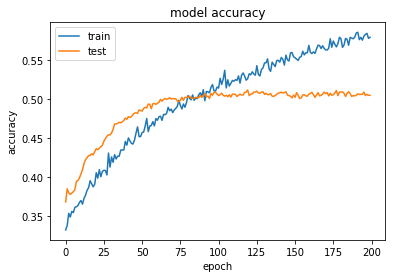

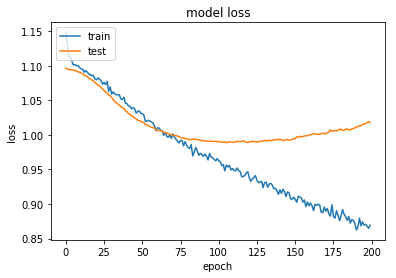

In [347]:
# printing

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing

In [348]:
model.load_weights("dl_emaus.hdf5")

# test dataset
score_test = model.evaluate(x_val_k, y_val_k, verbose=0)
print('Validation loss:', score_test[0])
print('Validation accuracy:', score_test[1])

Validation loss: 0.9886509097732223
Validation accuracy: 0.5048798798798799


In [349]:
y_prob_pred = model.predict(x_val_k)
y_pred = np.transpose(np.argmax(y_prob_pred, axis=1))
y_pred.shape

(2664,)

In [350]:
print(classification_report(y_pred, y_val))

             precision    recall  f1-score   support

          0       0.52      0.49      0.51       986
          1       0.25      0.56      0.35       394
          2       0.75      0.50      0.60      1284

avg / total       0.59      0.50      0.53      2664



In [351]:
confusion_matrix(y_pred, y_val)

array([[483, 312, 191],
       [152, 221,  21],
       [290, 353, 641]])

## Submission

Because the number of features is slightly different with the whole set, we need to train it once again but with time with the whole data (X_train = x_train + x_val)

In [358]:
# we select 105 epochs which is the inflection point during the model training/testing
# this is early-stopping, a way to reduce over-fitting
epochs = 105


model = Sequential()


# fully connected layers
# layer1
model.add(Dense(layer1, activation='relu', input_dim=input_layer))
# input_dim is the number of inputs

# dropout
model.add(Dropout(drop_prob))

# layer2
model.add(Dense(layer2, activation='relu'))

# dropout
model.add(Dropout(drop_prob))

# layer3
model.add(Dense(layer3, activation='relu'))

# dropout
model.add(Dropout(drop_prob))

# layer4
#model.add(Dense(layer4, activation='relu'))

# dropout
# model.add(Dropout(drop_prob))

# layer5
#model.add(Dense(layer5, activation='relu'))
# dropout
# model.add(Dropout(drop_prob))

# softmax layer
# the softmax layer produces probability
model.add(Dense(num_classes, activation='softmax'))


# Visualizing the model
model.summary()


# training

reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)


# this checkpointer lets save the weights
# the option save_best_only is useful because it lets us save only the model with the best loss
# so in case of overfitting, it lets us doing early-stopping

checkpointer = ModelCheckpoint(
    filepath="dl_emaus.hdf5", verbose=1, save_best_only=True)


model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_k, Y_train_k,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[reduce_lr, checkpointer],
                    shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 128)               30464     
_________________________________________________________________
dropout_68 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_69 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_91 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_70 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 3)                 99        
Total para

/Users/Selim/anaconda/lib/python3.6/site-packages/keras/callbacks.py:898: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/Users/Selim/anaconda/lib/python3.6/site-packages/keras/callbacks.py:406: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8880/8880 [==============================] - 2s 202us/step - loss: 1.1134 - acc: 0.3468
Epoch 3/105
8880/8880 [==============================] - 2s 192us/step - loss: 1.1040 - acc: 0.3551
Epoch 4/105
8880/8880 [==============================] - 2s 188us/step - loss: 1.1012 - acc: 0.3609
Epoch 5/105
8880/8880 [==============================] - 2s 188us/step - loss: 1.0980 - acc: 0.3584
Epoch 6/105
8880/8880 [==============================] - 2s 192us/step - loss: 1.0949 - acc: 0.3699 0s - loss: 1.0951 - acc
Epoch 7/105
8880/8880 [==============================] - 2s 193us/step - loss: 1.0937 - acc: 0.3745
Epoch 8/105
8880/8880 [==============================] - 2s 194us/step - loss: 1.0915 - acc: 0.3770
Epoch 9/105
8880/8880 [==============================] - 2s 194us/step - loss: 1.0871 - acc: 0.3744
Epoch 10/105
8880/8880 [==============================] - 2s 194us/step - loss: 1.0816 - acc: 0.3889
Epoch 11/105
8880/8880 [==============================] - 1s 167us/step - loss: 1.0812 

8880/8880 [==============================] - 1s 161us/step - loss: 0.9611 - acc: 0.5101
Epoch 84/105
8880/8880 [==============================] - 1s 161us/step - loss: 0.9542 - acc: 0.5144
Epoch 85/105
8880/8880 [==============================] - 1s 161us/step - loss: 0.9568 - acc: 0.5158
Epoch 86/105
8880/8880 [==============================] - 1s 161us/step - loss: 0.9477 - acc: 0.5218
Epoch 87/105
8880/8880 [==============================] - 1s 161us/step - loss: 0.9503 - acc: 0.5193
Epoch 88/105
8880/8880 [==============================] - 1s 161us/step - loss: 0.9543 - acc: 0.5196
Epoch 89/105
8880/8880 [==============================] - 1s 161us/step - loss: 0.9537 - acc: 0.5179
Epoch 90/105
8880/8880 [==============================] - 1s 161us/step - loss: 0.9522 - acc: 0.5199
Epoch 91/105
8880/8880 [==============================] - 1s 161us/step - loss: 0.9506 - acc: 0.5170
Epoch 92/105
8880/8880 [==============================] - 1s 161us/step - loss: 0.9462 - acc: 0.5221
Epo

In [359]:
Y_prob_pred = model.predict(X_test_k)
df_submission = pd.DataFrame(Y_prob_pred, index=X_test.index)
df_submission.to_csv("my_prediction_nn2.csv",
                     index_label="id", header=['0', '1', '2'])

I scored <b>0.99662</b> on the platform with this model.  